In [1]:
import numpy as np
import pandas as pd
import polars as pl


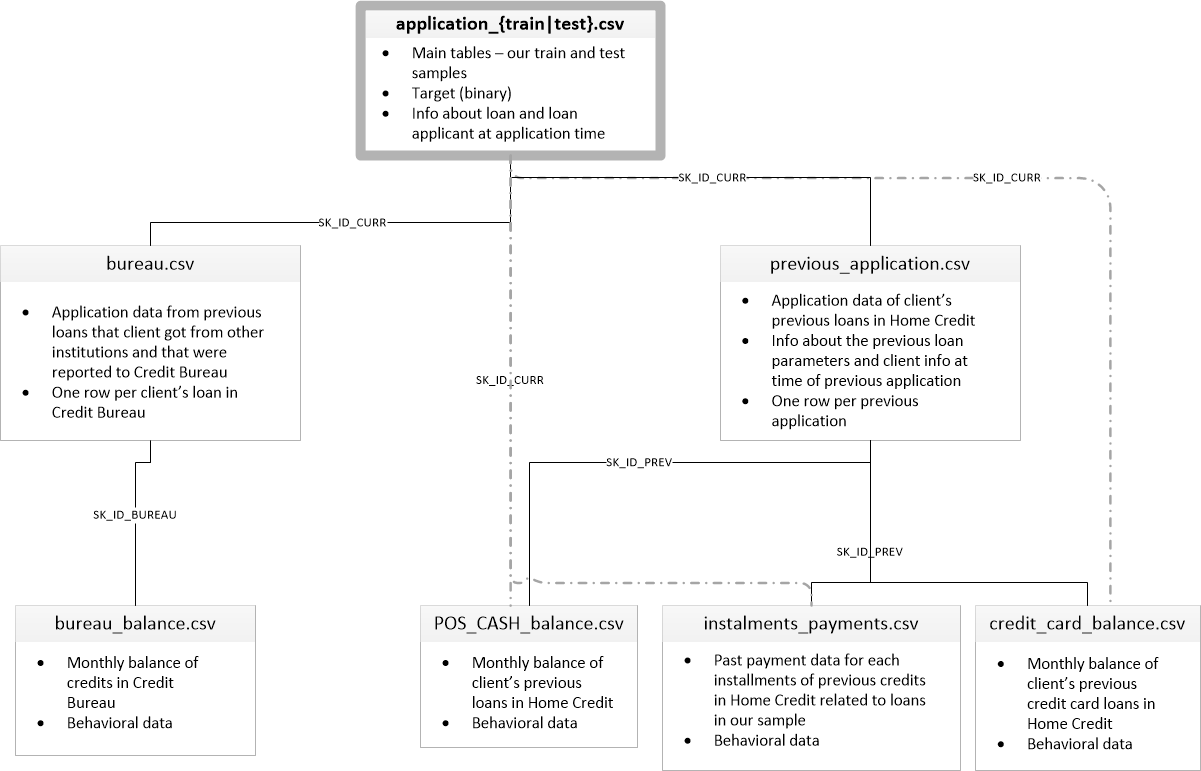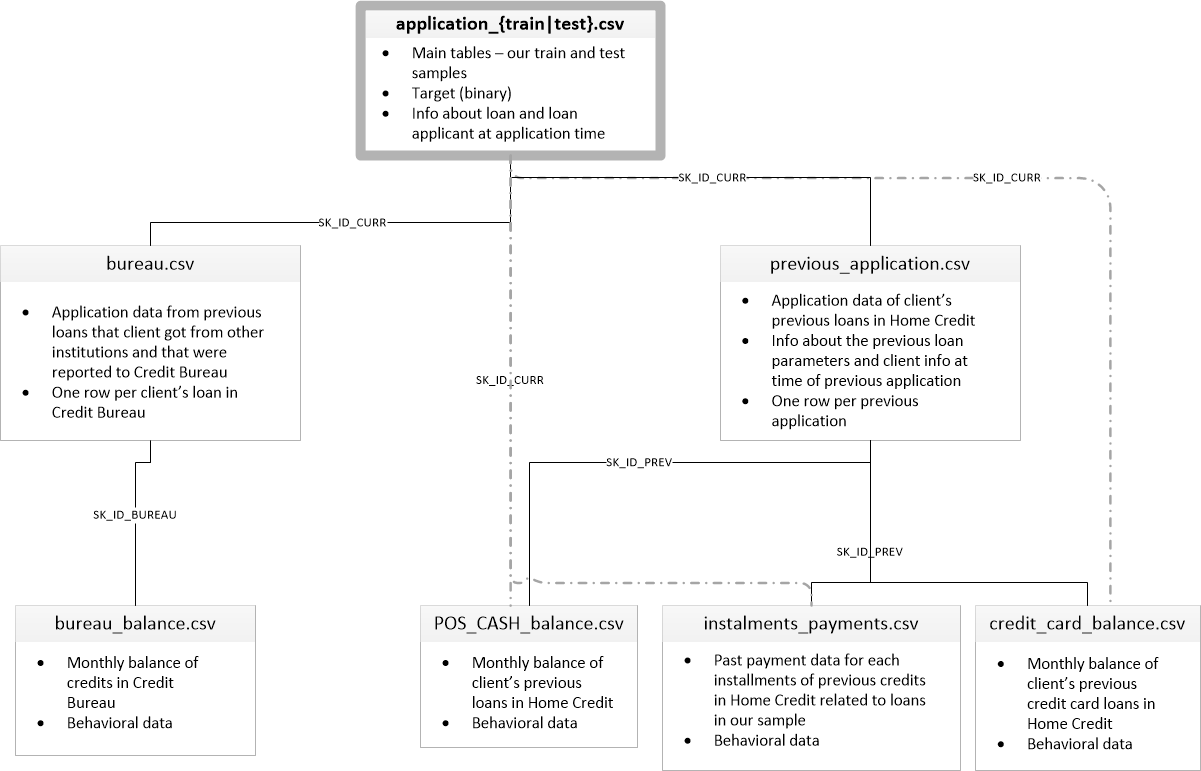

## Scanning tables using lazy load

In [6]:
lazy_application_train_df = pl.scan_csv("data/application_train.csv")
lazy_bureau_df = pl.scan_csv("data/bureau.csv")
lazy_bureau_balance_df = pl.scan_csv("data/bureau_balance.csv")

lazy_prev_application_df = pl.scan_csv("data/previous_application.csv")
lazy_cred_card_balance_df = pl.scan_csv("data/credit_card_balance.csv")
lazy_pos_cash_balance_df = pl.scan_csv("data/POS_CASH_balance.csv")
lazy_install_payments_df = pl.scan_csv("data/installments_payments.csv")


## bureau data

In [11]:
bureau_balance_df = lazy_bureau_balance_df.collect()

bureau_df.schema, bureau_balance_df.schema

(OrderedDict([('SK_ID_CURR', Int64),
              ('SK_ID_BUREAU', Int64),
              ('CREDIT_ACTIVE', Utf8),
              ('CREDIT_CURRENCY', Utf8),
              ('DAYS_CREDIT', Int64),
              ('CREDIT_DAY_OVERDUE', Int64),
              ('DAYS_CREDIT_ENDDATE', Float64),
              ('DAYS_ENDDATE_FACT', Float64),
              ('AMT_CREDIT_MAX_OVERDUE', Float64),
              ('CNT_CREDIT_PROLONG', Int64),
              ('AMT_CREDIT_SUM', Float64),
              ('AMT_CREDIT_SUM_DEBT', Float64),
              ('AMT_CREDIT_SUM_LIMIT', Float64),
              ('AMT_CREDIT_SUM_OVERDUE', Float64),
              ('CREDIT_TYPE', Utf8),
              ('DAYS_CREDIT_UPDATE', Int64),
              ('AMT_ANNUITY', Utf8)]),
 OrderedDict([('SK_ID_BUREAU', Int64),
              ('MONTHS_BALANCE', Int64),
              ('STATUS', Utf8)]))

In [12]:
#Grouping bureau_balance

grouped_bureau_balance_df = bureau_balance_df.group_by("SK_ID_BUREAU").agg([
    pl.col("MONTHS_BALANCE").mean().alias("meanMONTHS_BALANCE"),

    #taking quantiles
    pl.quantile("MONTHS_BALANCE", 0.25).alias("25Q_MONTHS_BALANCE"),
    pl.quantile("MONTHS_BALANCE", 0.75).alias("75Q_MONTHS_BALANCE"),
    pl.std("MONTHS_BALANCE").alias("STD_MONTHS_BALANCE"),
    pl.col("STATUS").last().alias("lastSTATUS"),
    pl.col("STATUS").mode().first().alias("modeSTATUS")
]).lazy()




In [16]:
#Joing bureau tables
merged_bureau_data = lazy_bureau_df.join(grouped_bureau_balance_df, on="SK_ID_BUREAU", how="left")

numerical_cols = [
    'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
    'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
    'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
    'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'meanMONTHS_BALANCE',
    'STD_MONTHS_BALANCE'
]

categorical_cols = [
    'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'lastSTATUS', 'modeSTATUS'
]


In [24]:
# Group by SK_ID_CURR and aggregate
grouped_bureau_df = merged_bureau_data.group_by("SK_ID_CURR").agg([
    # Apply mean and std for numerical columns
    *[pl.col(col).mean().alias(f'{col}_mean') for col in numerical_cols],
    *[pl.col(col).std().alias(f'{col}_std') for col in ["AMT_CREDIT_SUM", ["CNT_CREDIT_PROLONG"]]],
    # Apply mode for categorical columns
    *[pl.col(col).mode().first().alias(f'{col}_mode') for col in categorical_cols]  # Using mode().first() to get the single mode value
])



In [25]:
grouped_bureau_df = grouped_bureau_df.collect()


In [30]:
#saving intermediat step
grouped_bureau_df.write_csv("processsing/grouped_bureau.csv", float_precision=3)